# Prediciting How deep into the tournament a team is expected to go

I wanto to slightly bias angainst eliminiting teams that are expected to make a deep run

By nature of the scoring, if a matchup is 50/50 in the head to hea model, but one team has a chance to win it all while the other team doesn't (I know it's not a common scenario but sometimes a 'bad' team could matchup well against a 'good' team) I want the team that can make a deep run to be selected sligtly more.

To do that, I do need a model that predicts either P(Make the final four) or E[Round of elimination]

Since the target in the second one is categorical, but still very much ordinal, Im not sure if its better to treat it as a regression or a multi-class classification problem.

If I go with option #1 (P(make final Four)), I have to remember that those two classes will be very imbalanced, but there are ways to deal with that.



In [2]:
import os
import pandas as pd
import numpy as np
import sklearn
import random
import time
from sklearn.model_selection import train_test_split


In [3]:
os.chdir('C:\\Users\\Nick\\Python Projects\\2024 March Madness\\MMML')

In [4]:
MTeams = pd.read_csv('Data\\MTeams.csv')
WTeams = pd.read_csv('Data\\WTeams.csv')

MTeamInfo = pd.read_csv('Data\\MTeamInfo.csv')
WTeamInfo = pd.read_csv('Data\\WTeamInfo.csv')

MTourneyResults = pd.read_csv('Data\\MNCAATourneyCompactResults.csv')
WTourneyResults = pd.read_csv('Data\\WNCAATourneyCompactResults.csv')

MTourneySeeds = pd.read_csv('Data\\MNCAATourneySeeds.csv')
WTourneySeeds = pd.read_csv('Data\\WNCAATourneySeeds.csv')

MSlots = pd.read_csv('Data\\MNCAATourneySlots.csv')
WSlots = pd.read_csv('Data\\WNCAATourneySlots.csv')

Start by figuring out how far each team made it in the tourney


In [5]:
MTourneyResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2446,2023,146,1274,88,1400,81,N,0
2447,2023,146,1361,57,1166,56,N,0
2448,2023,152,1163,72,1274,59,N,0
2449,2023,152,1361,72,1194,71,N,0


In [6]:
MTourneySeeds['RoundReached'] = 1
WTourneySeeds['RoundReached'] = 1
MTourneySeeds

,Season,Seed,TeamID,RoundReached
0,1985,W01,1207,1
1,1985,W02,1210,1
2,1985,W03,1228,1
3,1985,W04,1260,1
4,1985,W05,1374,1
...,...,...,...,...
2553,2024,Z12,1241,1
2554,2024,Z13,1436,1
2555,2024,Z14,1324,1
2556,2024,Z15,1443,1


### Finding Mens Rounds reached by team.

Once again I'm going to kind of just brut force this. Its not that much data
Start with mens

In [7]:
MTourneyResults.loc[MTourneyResults.Season == 2021].head(20)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2251,2021,136,1179,53,1455,52,N,0
2252,2021,136,1313,54,1111,53,N,0
2253,2021,136,1411,60,1291,52,N,0
2254,2021,136,1417,86,1277,80,N,1
2255,2021,137,1116,85,1159,68,N,0
2256,2021,137,1124,79,1216,55,N,0
2257,2021,137,1196,75,1439,70,N,1
2258,2021,137,1222,87,1156,56,N,0
2259,2021,137,1228,78,1180,49,N,0
2260,2021,137,1260,71,1210,60,N,0


In [158]:
#Filter out first four games
MTR = MTourneyResults.loc[(MTourneyResults.DayNum >= 137) | ((MTourneyResults.DayNum == 136) & (MTourneyResults.Season != 2021))]
MTR

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2446,2023,146,1274,88,1400,81,N,0
2447,2023,146,1361,57,1166,56,N,0
2448,2023,152,1163,72,1274,59,N,0
2449,2023,152,1361,72,1194,71,N,0


Quick test. I basically want to count how many games each team won. 2023 sdsu won 5 games, and thus made it to round 6

In [159]:
MTR.loc[(MTourneyResults.WTeamID == 1361) & (MTourneyResults.Season == 2023)]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2400,2023,136,1361,63,1158,57,N,0
2424,2023,138,1361,75,1202,52,N,0
2442,2023,144,1361,71,1104,64,N,0
2447,2023,146,1361,57,1166,56,N,0
2449,2023,152,1361,72,1194,71,N,0


This command ruturna a df of 5 rows which is what we want

In [160]:
start_time = time.time()
for i in range(len(MTourneySeeds)):
    team = MTourneySeeds.loc[i, 'TeamID']
    year =  MTourneySeeds.loc[i, 'Season']
    tmp = MTR.loc[(MTourneyResults.WTeamID == team) & (MTourneyResults.Season == year)]
    MTourneySeeds.loc[i, 'RoundReached'] = len(tmp) + 1
    
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 4.018717288970947 seconds


In [161]:
MTourneySeeds['ReachF4'] = MTourneySeeds['RoundReached'] >= 5

In [162]:
MTourneySeeds['Seed'] = MTourneySeeds['Seed'].str.replace(r'\D+', '', regex=True).astype(int)
MTourneySeeds

,Season,Seed,TeamID,RoundReached,ReachF4
0,1985,1,1207,6,True
1,1985,2,1210,4,False
2,1985,3,1228,3,False
3,1985,4,1260,3,False
4,1985,5,1374,2,False
...,...,...,...,...,...
2553,2024,12,1241,1,False
2554,2024,13,1436,1,False
2555,2024,14,1324,1,False
2556,2024,15,1443,1,False


Now for the final dataset. (for men). Merge the seeding and results data with teamInfo (season stats) Data.


In [163]:
MStats = pd.merge(MTourneySeeds, MTeamInfo, on=['TeamID', 'Season'], how='left')

In [164]:
MStats.groupby('Season')['RoundReached'].mean()

Season
1985    1.984375
1986    1.984375
1987    1.984375
1988    1.984375
1989    1.984375
1990    1.984375
1991    1.984375
1992    1.984375
1993    1.984375
1994    1.984375
1995    1.984375
1996    1.984375
1997    1.984375
1998    1.984375
1999    1.984375
2000    1.984375
2001    1.969231
2002    1.969231
2003    1.969231
2004    1.969231
2005    1.969231
2006    1.969231
2007    1.969231
2008    1.969231
2009    1.969231
2010    1.969231
2011    1.926471
2012    1.926471
2013    1.926471
2014    1.926471
2015    1.926471
2016    1.926471
2017    1.926471
2018    1.926471
2019    1.926471
2021    1.911765
2022    1.926471
2023    1.926471
2024    1.000000
Name: RoundReached, dtype: float64

Unfortunatley I only have game stats from 2003 onward. I will have to drop everything before that

In [165]:
MensData = MStats.loc[(MStats.Season >= 2003)]
MensData.isna().sum()

Season               0
Seed                 0
TeamID               0
RoundReached         0
ReachF4              0
Wins                 0
Losses               0
Conference           0
SOS                  0
ConfWins             0
ConfLosses           0
ConfSOS              0
P_PG                 0
PA_PG                0
FGM_PG               0
FGM3_PG              0
OR_PG                0
DR_PG                0
Ast_PG               0
TO_PG                0
Stl_PG               0
Blk_PG               0
PF_PG                0
Opp_FGM_PG           0
Opp_FGM3_PG          0
Opp_OR_PG            0
Opp_DR_PG            0
Opp_Ast_PG           0
Opp_TO_PG            0
Opp_Stl_PG           0
Opp_Blk_PG           0
Opp_PF_PG            0
FG_PCT               0
FG_PCT3              0
FT_PCT               0
Opp_FG_PCT           0
Opp_FG_PCT3          0
Opp_FT_PCT           0
POSS_PER_GAME        0
Opp_POSS_PER_GAME    0
DREB_PCT             0
OREB_PCT             0
EFG_PCT              0
Opp_EFG_PCT

In [166]:
MConf = pd.read_csv('Data\\MConferenceTourneyGames.csv')


#### Add indicator if team won conference tourney

In [169]:
ConfL = MConf.groupby(['LTeamID', 'Season'])['DayNum'].count().reset_index().rename(columns = {'DayNum':'WonConf', 'LTeamID':'TeamID'})
MensData = pd.merge(MensData, ConfL, on = ['Season', 'TeamID'], how = 'left')
MensData = MensData.fillna(2)
MensData['WonConf'] = MensData.WonConf -1
MensData

,Season,Seed,TeamID,RoundReached,ReachF4,Wins,Losses,Conference,SOS,ConfWins,...,EFG_PCT,Opp_EFG_PCT,OFF_RTG,DEF_RTG,NET_RTG,TOV_PCT,Ranking1,Ranking2,Ranking3,WonConf
0,2003,1,1328,4,False,24.0,6.0,big_twelve,0.582411,3.0,...,0.512972,0.446284,110.534708,92.756275,1.191668,0.183275,20.0,19.0,9.0,1.0
1,2003,2,1448,2,False,24.0,5.0,acc,0.548512,1.0,...,0.509940,0.458454,113.152343,97.803535,1.156935,0.217945,8.0,14.0,12.0,0.0
2,2003,3,1393,7,True,24.0,5.0,big_east,0.554094,1.0,...,0.512195,0.443703,111.393498,97.634048,1.140929,0.189412,12.0,20.0,15.0,0.0
3,2003,4,1257,2,False,24.0,6.0,cusa,0.560611,3.0,...,0.529041,0.448183,113.587993,94.958947,1.196180,0.185535,4.0,1.0,14.0,1.0
4,2003,5,1280,1,False,21.0,9.0,sec,0.574863,2.0,...,0.521804,0.458769,105.473604,90.844121,1.161039,0.234998,14.0,22.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,2024,12,1241,1,False,30.0,3.0,sun_belt,0.446943,3.0,...,0.544175,0.466788,114.428526,95.563965,1.197402,0.140424,75.0,70.0,59.0,1.0
1400,2024,13,1436,1,False,26.0,6.0,aec,0.497776,3.0,...,0.518262,0.467051,107.498764,97.069388,1.107442,0.128846,125.0,106.0,104.0,1.0
1401,2024,14,1324,1,False,23.0,11.0,horizon,0.502172,3.0,...,0.521130,0.506098,109.816719,105.042373,1.045452,0.155975,151.0,141.0,137.0,1.0
1402,2024,15,1443,1,False,19.0,11.0,cusa,0.464390,3.0,...,0.519076,0.482842,104.228891,97.799940,1.065736,0.175691,153.0,155.0,132.0,1.0


In [172]:
#Remove 2024 since that hasn't been played yet

MensDataPast = MensData.loc[MensData.Season != 2024]

PredictionData = MensData.loc[MensData.Season == 2024]

print(MensDataPast.shape, PredictionData.shape)

(1336, 52) (68, 52)


## Modelling Phase

In [ ]:
#Import libraries

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [133]:
MX = MensDataPast.drop(columns = ['TeamID', 'RoundReached', 'ReachF4'])
My = MensDataPast['RoundReached']

MX_train, MX_test, My_train, My_test = train_test_split(MX, My, test_size=0.2, random_state=123)

# Print the shapes of the train and test sets
print("Shape of X_train:", MX_train.shape)
print("Shape of X_test:", MX_test.shape)
print("Shape of y_train:", My_train.shape)
print("Shape of y_test:", My_test.shape)

Shape of X_train: (1068, 49)
Shape of X_test: (268, 49)
Shape of y_train: (1068,)
Shape of y_test: (268,)


In [134]:
MX_train.columns

Index(['Season', 'Seed', 'Wins', 'Losses', 'Conference', 'SOS', 'ConfWins',
       'ConfLosses', 'ConfSOS', 'P_PG', 'PA_PG', 'FGM_PG', 'FGM3_PG', 'OR_PG',
       'DR_PG', 'Ast_PG', 'TO_PG', 'Stl_PG', 'Blk_PG', 'PF_PG', 'Opp_FGM_PG',
       'Opp_FGM3_PG', 'Opp_OR_PG', 'Opp_DR_PG', 'Opp_Ast_PG', 'Opp_TO_PG',
       'Opp_Stl_PG', 'Opp_Blk_PG', 'Opp_PF_PG', 'FG_PCT', 'FG_PCT3', 'FT_PCT',
       'Opp_FG_PCT', 'Opp_FG_PCT3', 'Opp_FT_PCT', 'POSS_PER_GAME',
       'Opp_POSS_PER_GAME', 'DREB_PCT', 'OREB_PCT', 'EFG_PCT', 'Opp_EFG_PCT',
       'OFF_RTG', 'DEF_RTG', 'NET_RTG', 'TOV_PCT', 'Ranking1', 'Ranking2',
       'Ranking3', 'WonConf'],
      dtype='object')

### Random Forest

Starting with a random forest so i dont have to scale data for it yet

In [135]:
numeric_features = ['Season', 'Seed', 'Wins', 'Losses', 'SOS', 'P_PG',
       'PA_PG', 'FGM_PG', 'FGM3_PG', 'OR_PG', 'DR_PG', 'Ast_PG', 'TO_PG',
       'Stl_PG', 'Blk_PG', 'PF_PG', 'Opp_FGM_PG', 'Opp_FGM3_PG', 'Opp_OR_PG',
       'Opp_DR_PG', 'Opp_Ast_PG', 'Opp_TO_PG', 'Opp_Stl_PG', 'Opp_Blk_PG',
       'Opp_PF_PG', 'FG_PCT', 'FG_PCT3', 'FT_PCT', 'Opp_FG_PCT', 'Opp_FG_PCT3',
       'Opp_FT_PCT', 'POSS_PER_GAME', 'Opp_POSS_PER_GAME', 'DREB_PCT',
       'OREB_PCT', 'EFG_PCT', 'Opp_EFG_PCT', 'OFF_RTG', 'DEF_RTG', 'NET_RTG',
       'TOV_PCT', 'Ranking1', 'Ranking2', 'Ranking3', 'ConfWins']

categorical_features = ['Conference']

In [137]:
#Create Pipeline

preprocessor = make_column_transformer((StandardScaler(),numeric_features), 
                               (OneHotEncoder(),categorical_features))

pipe = make_pipeline(preprocessor, RandomForestRegressor())

In [53]:
scores = cross_val_score(pipe, MX_train, My_train)

In [54]:
scores


array([0.43798164, 0.29346825, 0.31721753, 0.12018704, 0.43554926])

In [49]:
pipe.fit(MX_train, My_train)

y_pred = pipe.predict(MX_test)

In [145]:
p = make_pipeline(preprocessor)

preprocessor.fit(MX, My)

MX_new = preprocessor.transform(MX)
MX_new

array([[-1.63158177, -1.6554128 ,  0.32358921, ...,  0.        ,
         0.        ,  0.        ],
       [-1.63158177, -1.44129415,  0.32358921, ...,  0.        ,
         0.        ,  0.        ],
       [-1.63158177, -1.22717551,  0.32358921, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.7116594 ,  1.12812961, -0.49934579, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.7116594 ,  1.34224825,  0.59790088, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.7116594 ,  1.5563669 , -1.04796913, ...,  0.        ,
         0.        ,  0.        ]])

In [50]:
mpreds = pd.DataFrame(My_test)
mpreds['pred'] = y_pred
mpreds['diff'] = mpreds['RoundReached']-mpreds['pred']
mpreds.sort_values('diff')

,RoundReached,pred,diff
928,2,4.98,-2.98
1217,3,5.24,-2.24
1286,1,3.21,-2.21
66,2,3.68,-1.68
1168,2,3.64,-1.64
...,...,...,...
35,5,2.78,2.22
178,7,4.43,2.57
351,4,1.39,2.61
1084,6,3.17,2.83


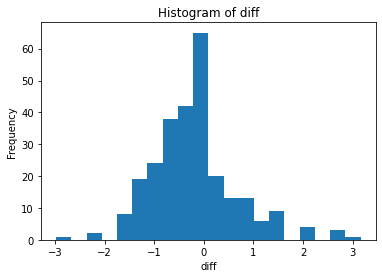

In [51]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'column_name' is the name of the column you want to plot
column_name = 'diff'

# Plot histogram
plt.hist(mpreds[column_name], bins=20)  # Adjust the number of bins as needed
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histogram of ' + column_name)
plt.show()

In [58]:
import matplotlib.pyplot as plt
import numpy as np

rf_model = RandomForestRegressor(n_estimators=200, 
                                   max_depth=3, 
                                   max_features=0.15,
                                   random_state=123)

# Assuming rf_model is your trained RandomForestRegressor model
rf_model.fit(MX_new, My)


# Get feature importances
importances = rf_model.feature_importances_

# Get names of features
feature_names = MX.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(MX_new.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(MX_new.shape[1]), feature_names[indices-1], rotation=90)
plt.xlim([-1, MX_new.shape[1]])
plt.tight_layout()
plt.show()

NameError: name 'MX_new' is not defined

### Tuning RF Hyperparameters

Some of these GridSearchCvs take a while to run. Skip if not interested. Not necessary that these cells are run. Cells below should run fine

In [54]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder#, TargetEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


In [58]:
start_time = time.time()
# Define the parameter grid
param_grid = {
    'randomforestregressor__n_estimators': [50, 100, 150],  # Adjust these values as needed
    'randomforestregressor__max_depth': [5, 10, 20],   # Adjust these values as needed
    'randomforestregressor__max_features': ['auto', 0.2, 'log2']
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(MX_train, My_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 0.2, 'randomforestregressor__n_estimators': 100}
Best score: -0.7623834779067551
Execution time: 12.029890537261963 seconds


In [62]:
start_time = time.time()
# Define the parameter grid
param_grid = {
    'randomforestregressor__n_estimators': [125, 150, 175],  # Adjust these values as needed
    'randomforestregressor__max_depth': [3,5,7],   # Adjust these values as needed
    'randomforestregressor__max_features': ['auto', 0.2, 0.33]
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(MX_train, My_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 0.33, 'randomforestregressor__n_estimators': 175}
Best score: -0.7593642184845466
Execution time: 14.63175916671753 seconds


In [63]:
start_time = time.time()
# Define the parameter grid
param_grid = {
    'randomforestregressor__n_estimators': [150, 175, 200],  # Adjust these values as needed
    'randomforestregressor__max_depth': [4,5,6],   # Adjust these values as needed
    'randomforestregressor__max_features': ['auto', 0.33, 0.4]
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(MX_train, My_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 0.4, 'randomforestregressor__n_estimators': 150}
Best score: -0.7589357192212461
Execution time: 18.65125584602356 seconds


In [59]:
# Plotting helper functions. Don't edit these.
%matplotlib inline
from IPython import display
from tqdm.notebook import tqdm_notebook
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

@ignore_warnings(category=ConvergenceWarning)
def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from the evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 1))
    ylabel -- the y-axis title
    """
    #print(res)
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)

    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
    plt.grid(True)

    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in tqdm_notebook(param_range):
        scores = evaluator(X, y, i)
        xvals.append(i)
        if not series:  # This checks if series dictionary is empty, meaning it's the first iteration
            for k in scores.keys():
                series[k] = [scores[k]]  # Initialize series with the first score
                lines[k], = plt.plot(xvals, series[k], marker=marker, label=k)  # Plot the initial point
        else:
            for k in scores.keys():
                series[k].append(scores[k])
                lines[k].set_data(xvals, series[k])

        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

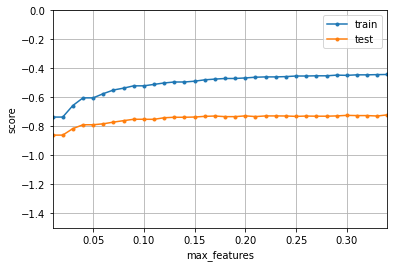

In [137]:
# MODEL IMPLEMENTATION:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

def evaluate_mf(X, y, MF):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(preprocessor, RandomForestRegressor(n_estimators=200, 
                                   max_depth=5, 
                                   max_features=MF,
                                   random_state=123)), X, y, return_train_score= True, cv=5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_mf(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_mf, 'max_features', np.arange(0.01, 0.35, 0.01), scale='linear', ylim=(-1.5,0))
plot_curve_mf(MX,My,0.25)

In [135]:
MX.shape

(1336, 47)

In [136]:
MX_train.shape

(1068, 47)

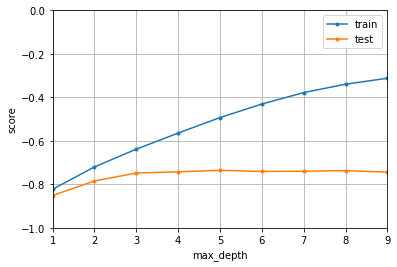

In [138]:
# MODEL IMPLEMENTATION:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

def evaluate_md(X, y, MD):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(preprocessor, RandomForestRegressor(n_estimators=200, 
                                   max_depth=MD, 
                                   max_features=0.14,
                                   random_state=123)), X, y, return_train_score= True, cv=5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_md(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_md, 'max_depth', np.arange(1, 10, 1), scale='linear', ylim=(-1,0))
plot_curve_md(MX,My,0.25)

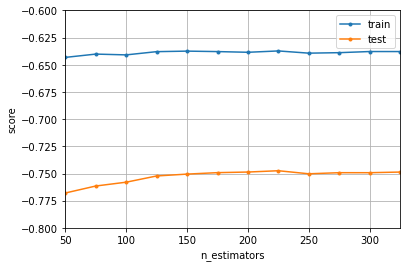

In [122]:
# MODEL IMPLEMENTATION:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

def evaluate_ne(X, y, NE):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(preprocessor, RandomForestRegressor(n_estimators=NE, 
                                   max_depth=3, 
                                   max_features=0.14,
                                   random_state=123)), X, y, return_train_score= True, cv=5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_ne(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_ne, 'n_estimators', np.arange(50, 350, 25), scale='linear', ylim=(-0.8,-0.6))
plot_curve_ne(MX,My,0.25)

What did we wlearn
-Max features shows slight improvement as it gets higher
-Max_depth is what drives the overfitting. Keep at 3
-n_estimators anything above like 150 should be sufficient

In [99]:
type(MX_train.values)

numpy.ndarray

letsn go with max_features = 0.14, n_estimators = 200, max_depth = 3

## XGBoost regressor

In [139]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel



In [140]:
selector = SelectFromModel(RandomForestRegressor(), threshold='mean')

pipe = make_pipeline(preprocessor, XGBRegressor())

In [141]:


start_time = time.time()

# Define the parameter grid including learning rate
param_grid = {
    'xgbregressor__n_estimators': [50, 100, 150],
    'xgbregressor__max_depth': [3, 5, 7],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.3],  # Include learning rate here
    'xgbregressor__gamma': [0, 0.1, 0.2]
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(MX_train, My_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 150}
Best score: -0.749283567531118
Execution time: 59.06914234161377 seconds


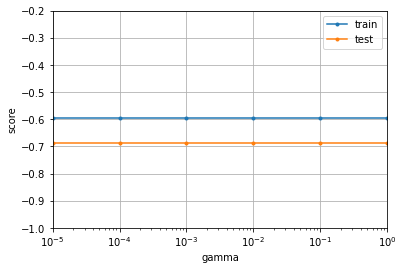

In [142]:

# MODEL IMPLEMENTATION:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

def evaluate_gamma(X, y, gamma):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(preprocessor, XGBRegressor(n_estimators=200,  # Smallest value for n_estimators 
                                                                    max_depth=2,      # Smallest value for max_depth
                                                                    learning_rate=0.008,  # Smallest value for learning_rate
                                                                    gamma=gamma           # Smallest value for gamma
                                                                   )), X, y, return_train_score= True, cv=5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_gamma(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_gamma, 'gamma', np.logspace(-5, 0, num=6), scale='log', ylim=(-1,-0.2))
plot_curve_gamma(MX,My,0.25)


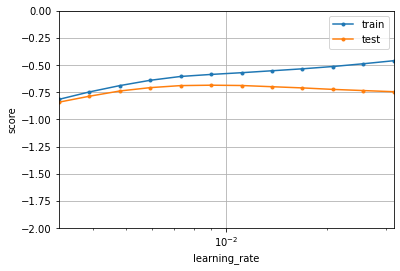

In [145]:

# MODEL IMPLEMENTATION:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

def evaluate_lr(X, y, lr):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(preprocessor, XGBRegressor(n_estimators=200,  # Smallest value for n_estimators 
                                                                    max_depth=2,      # Smallest value for max_depth
                                                                    learning_rate=lr,  # Smallest value for learning_rate
                                                                    gamma=0.001           # Smallest value for gamma
                                                                   )), X, y, return_train_score= True, cv=5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_lr(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_lr, 'learning_rate', np.logspace(-2.5, -1.5, num=12), scale='log', ylim=(-2,0))
plot_curve_lr(MX,My,0.25)


In [63]:
np.logspace(-2.5, -1.5, num=12)

array([0.00316228, 0.0038986 , 0.00480638, 0.00592553, 0.00730527,
       0.00900628, 0.01110336, 0.01368875, 0.01687612, 0.02080568,
       0.02565021, 0.03162278])

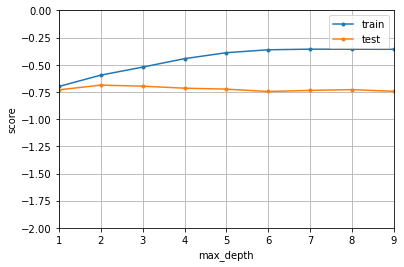

In [144]:
def evaluate_md(X, y, md):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(preprocessor, XGBRegressor(n_estimators=200,  # Smallest value for n_estimators 
                                                                    max_depth=md,      # Smallest value for max_depth
                                                                    learning_rate=0.0081,  # Smallest value for learning_rate
                                                                    gamma=0.001           # Smallest value for gamma
                                                                   )), X, y, return_train_score= True, cv=5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_md(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_md, 'max_depth', np.arange(1,10,1), scale='linear', ylim=(-2,0))
plot_curve_md(MX,My,0.25)

## Final Models

I could still do feature selection. If I have time I will

In [146]:
# XGBoost

pipetunedboost = make_pipeline(preprocessor, selector, XGBRegressor(n_estimators=200,  # Smallest value for n_estimators 
                                                                    max_depth=2,      # Smallest value for max_depth
                                                                    learning_rate=0.00904,  # Smallest value for learning_rate
                                                                    gamma=0.001           # Smallest value for gamma
                                                                   ))

pipetunedboost.fit(MX_train, My_train)

from sklearn.metrics import mean_absolute_error

# Make predictions on the test set
y_pred = pipetunedboost.predict(MX_test)

# Calculate mean squared error (MSE) on the test set
mae = mean_absolute_error(My_test, y_pred)

print("Test set mean absolute error:", mae)

Test set mean absolute error: 0.579871273307658


In [149]:
# Random Forest

pipetunerf = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=200, 
                                   max_depth=3, 
                                   max_features=0.14,
                                   random_state=123))

pipetunerf.fit(MX_train, My_train)

from sklearn.metrics import mean_absolute_error

# Make predictions on the test set
y_pred = pipetunerf.predict(MX_test)

# Calculate mean squared error (MSE) on the test set
mae = mean_absolute_error(My_test, y_pred)

print("Test set mean absolute error:", mae)

Test set mean absolute error: 0.6466963814951467


## Predictions

In [184]:
PredData = PredictionData.drop(columns = ['RoundReached', 'ReachF4', 'TeamID'])
OutputTable = PredictionData[['Season','TeamID']]

In [185]:
MTeams = pd.read_csv('Data\\MTeams.csv')

In [191]:
Out = OutputTable.merge(MTeams, on = 'TeamID', how = 'left')

In [187]:
print(PredData.shape, MX_test.shape)

(68, 49) (268, 49)


In [188]:
preds = pipetunedboost.predict(PredData)

In [192]:
Out['Pred'] = preds

In [193]:
Output = Out[['TeamID', 'TeamName', 'Pred']]

In [196]:
Output.sort_values('Pred').tail(50)

,TeamID,TeamName,Pred
45,1270,McNeese St,1.213382
63,1241,James Madison,1.217863
10,1182,Duquesne,1.273575
11,1412,UAB,1.273575
62,1301,NC State,1.312590
27,1213,Grand Canyon,1.324046
44,1332,Oregon,1.330268
43,1438,Virginia,1.330268
9,1179,Drake,1.401094
8,1321,Northwestern,1.418772


In [197]:
## Uncomment to save

#Output.to_csv('Data\\PredsMRound.csv')